In [1]:
from tensorflow.keras import datasets
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

In [0]:
# https://blog.keras.io/building-autoencoders-in-keras.html

In [0]:
image_shape = (28, 28, 1)
batch_size = 32
latent_dim = 2
kernel_size = 3
filters = 16
epochs = 30

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
inputs = Input(shape=image_shape)
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
___________

In [6]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(np.prod(shape[1:]), activation='relu')(latent_inputs)
x = Reshape(shape[1:])(x)
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same')(x)

decoder = Model(latent_inputs, outputs)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________

In [7]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
model (Model)                (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [8]:
xent_loss = 28 * 28 * binary_crossentropy(K.flatten(inputs), 
                                     K.flatten(outputs))

kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [0]:
def load_data():
  (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
  X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
  X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))
  X_train, X_test = X_train.astype('float64') / 255., X_test.astype('float64') / 255.
  return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = load_data()

In [11]:
early_stopping_monitor = callbacks.EarlyStopping(patience=2)

vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[early_stopping_monitor])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 13s 210us/sample - loss: 191.6765 - val_loss: 170.1529
Epoch 2/30
60000/60000 [==============================] - 11s 180us/sample - loss: 163.9683 - val_loss: 160.2263
Epoch 3/30
60000/60000 [==============================] - 11s 181us/sample - loss: 159.0007 - val_loss: 158.0777
Epoch 4/30
60000/60000 [==============================] - 11s 180us/sample - loss: 156.8238 - val_loss: 156.3414
Epoch 5/30
60000/60000 [==============================] - 11s 181us/sample - loss: 155.4041 - val_loss: 154.7498
Epoch 6/30
60000/60000 [==============================] - 11s 181us/sample - loss: 154.2847 - val_loss: 153.9668
Epoch 7/30
60000/60000 [==============================] - 11s 180us/sample - loss: 153.4675 - val_loss: 153.8024
Epoch 8/30
60000/60000 [==============================] - 11s 179

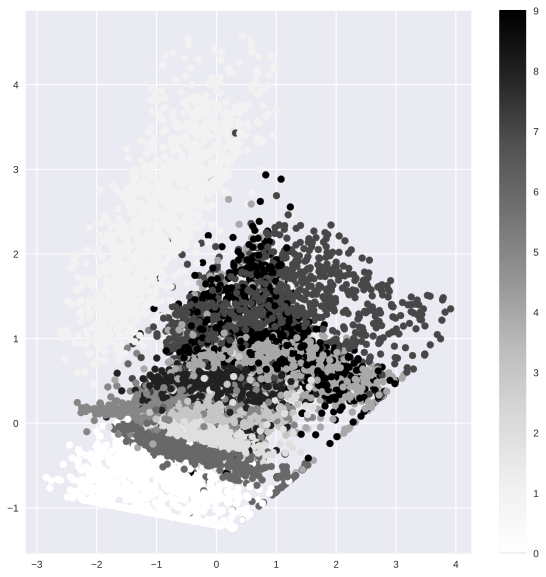

In [12]:
X_test_encoded, _, _ = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

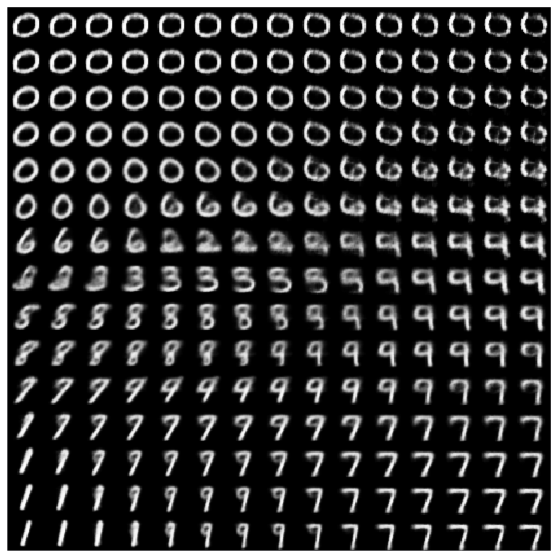

In [14]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-1, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.xticks([]); plt.yticks([])
plt.show()